# HEINZ NON-PROFIT ANALYTICS - GROUP 8
Sharanya Jaishankar, Adarsh Saboo

DATA SCRAPING FROM TED.COM

Part 1:
1. Scraping from Ted website (pages 1 to 77)
2. Get Data from each of those pages which had talks in 2017.
3. Merge it with Data downloaded from Dataworld.io.
4. Use tweepy library and Twitter API to get follower count of few speakers.
5. Merge all together and write to file. (This might take half an hour to run) 

# To start from the Data Analysis Part, proceed to step 2 after downloading the required CSVs from the github url.


Data Files required to run the whole notebook: DataFiles.xlsx, Ted_Trasncript_CSV.csv, Word_Dictionary.csv

Import the necessary packages for use in the project.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt 
from matplotlib.pyplot import pie, axis, show
import wordcloud
import seaborn as sea
from bs4 import BeautifulSoup
import requests
import re
import csv
import time
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import names
import warnings
from pylab import rcParams
import tweepy
from wordcloud import WordCloud

Scraping from the pages containing links and details of all the talks.

In [ ]:
finalResult = []

# Scrape all the pages containing list of the talks (77 in total)
for i in range(1,77):
    comments = requests.get('https://www.ted.com/talks?page='+str(i)+'&sort=newest')
    comments = comments.content
    soup = bs(comments, 'html.parser')
    
   
    linkset = soup.find('div',{'class':'results'}).find_all('div',{'class':'col'})
    
    links = []
    
    # Get the Month, Year and the Tags. If not found, put NA to keep the length during merging consistent 
    for i in range(0,len(linkset)):
        temp = linkset[i].find_all('span',{'class':'meta__val'})
        if len(temp)==2:
            str1 = temp[0].text.strip('\n')
            str2 = temp[1].text.strip('\n')
            links.append([str1,str2])
        else:
            links.append(['NA','NA'])
    
    # Fetch the URL of each talk.
    name_links = []
    for i in range(0,len(linkset)):
        temp = linkset[i].find_all('a',{'class':' ga-link'}, text = True)    
        name_links.append([temp[0]['href'],temp[0].text.strip('\n')])
    
    # For only links in the year 2017
    for i in range(0,len(name_links)):
        if '2017'in links[i][0]:
            finalResult.append(['https://www.ted.com'+name_links[i][0],name_links[i][1],links[i][0],links[i][1]])
    
    # ted.com has a limit to frequency of requests from a particular device. This delay will circumvent that.
    time.sleep(5)

datasource0 = pd.DataFrame(columns=['URL', 'Title', 'Date', 'Tags'],)    
datasource1 = pd.DataFrame(columns=['Title', 'Author', 'Views'],)

# Write the contents to file
with open("links_required.csv",'w',newline='') as resultFile:
        wr = csv.writer(resultFile, dialect='excel')
        wr.writerows(finalResult)       

NOTE: For convenience purposes, we have included a print statement that mentions the number of the page that has been currently scraped. Should it get stuck inbetween because of too many requests, the for loop can be re started from the last shown page number on the console, instead of starting from 0

In [ ]:
datasource0=pd.read_csv("links_required.csv", encoding = "ISO-8859-1", header=None)
for i in range(0, len(datasource0)):
    print("Currently Scraping Page ", i)
    a = requests.get(datasource0.iloc[i][0])
    soup = bs(a.text, "html.parser")
    span = soup.find_all("span")
    views = span[4].text.replace("\n", "").replace("\t", "").replace(" views", "")
    b = soup.find_all("title")
    titleandauthor = b[0].text.split(":")
    author = titleandauthor[0]
    title = titleandauthor[1].split("|")[0]
    datasource1.loc[i]=[title,author,views]
    time.sleep(4)

#write the individual ted talks data frame to a csv
datasource1.to_csv('datasourceMain1.csv',header=False, sep=',')

#read the required csv to concatenate
datasource_withTags=pd.read_csv("links_required.csv", encoding = "ISO-8859-1", header=None)
datasource_withViews=pd.read_csv("datasourceMain1.csv", encoding = "ISO-8859-1", header=None)

tempfinal = pd.concat([datasource_withTags, datasource_withViews], axis = 1)
final = tempfinal.iloc[:,[1,2,3,4,6,7]]
final.to_csv('Ted_Clean.csv',header = False, sep = ',')

#scrape raw sources and write to csv
df_raw_mainPage= pd.DataFrame(columns=['Raw Source'],)  

for i in range(1,77):
    comments = requests.get('https://www.ted.com/talks?page='+str(i)+'&sort=newest')
    comments = comments.content
    soup = bs(comments, 'html.parser')
    df_raw_mainPage.loc[i]=[soup]
    
print(df_raw_mainPage)
df_raw_mainPage.to_csv('ted_raw_mainPage1.csv',header=False, sep=',')

# Merge the two downloaded data set with the cleaned scraped data
datasource_fromDownloaded_CSV=pd.read_csv("Ted_Trasncript_CSV.csv", encoding = "ISO-8859-1",dtype='unicode',low_memory=False)
trasncriptDF = final.merge(datasource_fromDownloaded_CSV, left_on='Title',right_on='Title', how='right')
trasncriptDF.to_csv('ted_merged_transcript1.csv',header=False, sep=',')

Fetch data from the Twitter API (Tweepy)

In [43]:
# Variables that contains the user credentials to access Twitter API 
access_token = "795931597308444673-PVeafBP9DBm3dizz5bYnSucbSp7r6Kx"
access_token_secret = "H2IdimURTKCWZHOeihnwcWmiHHEVUu8KgQCLiM9nKdXXR"

consumer_key = "QUOEqeQurX0jE6Rw3p9UYKSUc"
consumer_secret = "kruSQBAUJjQt7qciL1nhCVTA52cbPp0MZlrzwkl4uAtCijgPB0"
speakers=['elonmusk','iamsrk','meganphelps','anilkseth','tferriss', 'AdamMGrant', 'EmEsfahaniSmith', 'Sue_Klebold']
followerCount=pd.DataFrame(columns=['Speaker', 'TwitterFollowersCount'],)
speakerids=[]

# Tweepy OAuthHandler
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

targets=[]

#reference: https://gist.github.com/cristovaov/98c3501b07025b939275
for i in range(0, len(speakers)):
    user = api.get_user(screen_name = speakers[i])
    userProfile = api.get_user(user.id)
    followerCount.loc[i]=[userProfile.name, userProfile.followers_count]
    print(userProfile.name, userProfile.followers_count)

followerCount.to_csv('TwitterApi_FollowerCount.csv', header=False, sep=',')

Elon Musk 21625710
Shah Rukh Khan 35216542
Megan Phelps-Roper 51448
Anil Seth 11645
Tim Ferriss 1550642
Adam Grant 155448
Emily Esfahani Smith 7487
Sue Klebold 123


# Part 2 - Exploratory Data Analysis

Load Data Files from the DataFiles.xlsx file, from various tabs into the appropriate data frame





In [56]:
xlsx = pd.ExcelFile('DataFiles.xlsx',encoding = "ISO-8859-1",dtype='unicode')
df_perTalk = pd.read_excel(xlsx, 5)
warnings.filterwarnings('ignore')
define_font = {'fontname':'Comic Sans MS', 'size':'16'}

# 2.1. Tag Analysis
Find the Maximum Tags reported for talks in the year 2017

                      index  Tags
0    Inspiring, Informative    44
1    Informative, Inspiring    42
2  Informative, Fascinating    41
3     Inspiring, Courageous    29
4   Informative, Persuasive    24
5      Inspiring, Beautiful    19
6      Beautiful, Inspiring    16
AxesSubplot(0.125,0.125;0.775x0.755)


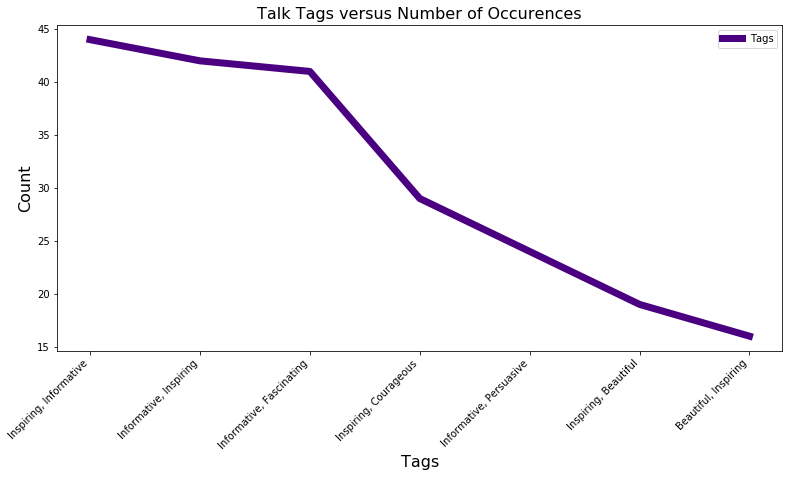

In [55]:
#Group by Tags and their counts
tags_counts = df_perTalk['Tags'].value_counts()
top_tags_counts = tags_counts.head(7)
df=top_tags_counts.to_frame().reset_index()
print(df)

#Plot the graph
plot1=df.plot(color="indigo", figsize= (13, 6), kind='line', linewidth=7, )
plot1.set_xticklabels(df.iloc[:,0], rotation=45, ha="right")
plot1.set_xticks(np.arange(len(df.iloc[:,0])))
plot1.set_xlabel('Tags', **define_font)
plot1.set_ylabel('Count', **define_font)
plot1.set_title('Talk Tags versus Number of Occurences', **define_font)

print(plot1)

# We find that "Inspiring and Informative" Speeches had the highest count in 2017.

Now, let us group the speeches by the tags based on the average number of views for the video on the website.

                                 Views
Tags                                  
Beautiful, Courageous     9.925295e+05
Beautiful, Fascinating    9.329233e+05
Beautiful, Inspiring      1.093667e+06
Courageous, Informative   1.012293e+06
Courageous, Inspiring     1.467966e+06
Fascinating, Funny        8.358300e+05
Fascinating, Informative  1.839953e+06


Text(0.5,1,'Talk Tags versus Number of Views of Video')

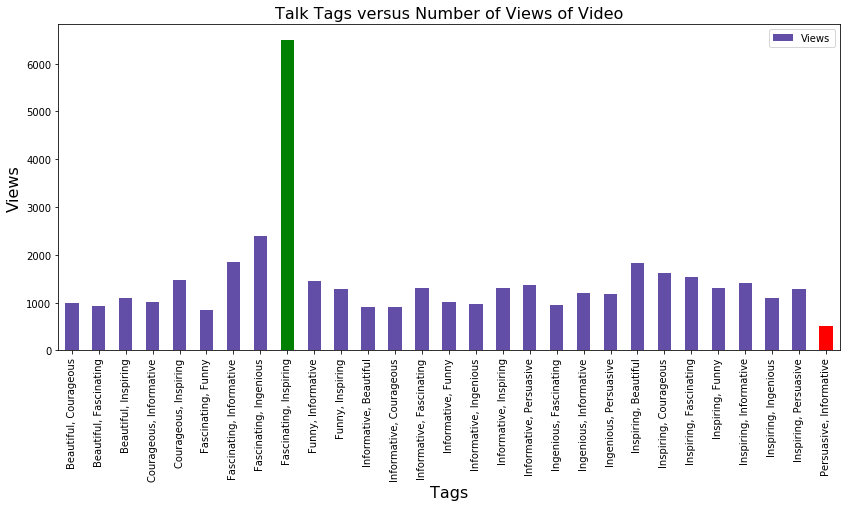

In [54]:
# Group by the different tags.
views_byTags = df_perTalk.groupby('Tags').agg({'Views':'mean'})
print(views_byTags.dropna().head(7))
#Divide Views by 1000 so as to fit in the graph and make it readable
views_byTags['Views']=views_byTags['Views']/1000
#Define colors required
colors = ['#624ea7', 'purple', '#624ea7', 'green', 'red']
#Drop NAN values
views_byTags=views_byTags.dropna()

plot_tag = views_byTags.plot(kind='bar', color=colors, legend=False, figsize= (14, 6))

for bar in plot_tag.patches:
    bar.set_facecolor('#624ea7')

#plot the graph 
highlight = 'Fascinating, Inspiring'
pos = views_byTags.index.get_loc(highlight)
plot_tag.patches[pos].set_facecolor('green')
highlight = 'Persuasive, Informative'
pos = views_byTags.index.get_loc(highlight)
plot_tag.patches[pos].set_facecolor('red')
plot_tag.legend()
plot_tag.set_xlabel('Tags', **define_font)
plot_tag.set_ylabel('Views', **define_font)
plot_tag.set_title('Talk Tags versus Number of Views of Video', **define_font)

# We see that talks with the tag "Fascinating and Inspiring" have received an exorbidant number of views when compared to the other tags that succeed it. "Persuasive and Informative" Talks have received the least number of views.

To investigate the reason behind the Fascinating and Inspiring Talks, let us look at the transcript of the talks that feel under this category. We first simulate a word cloud followed by sentiment analyis.

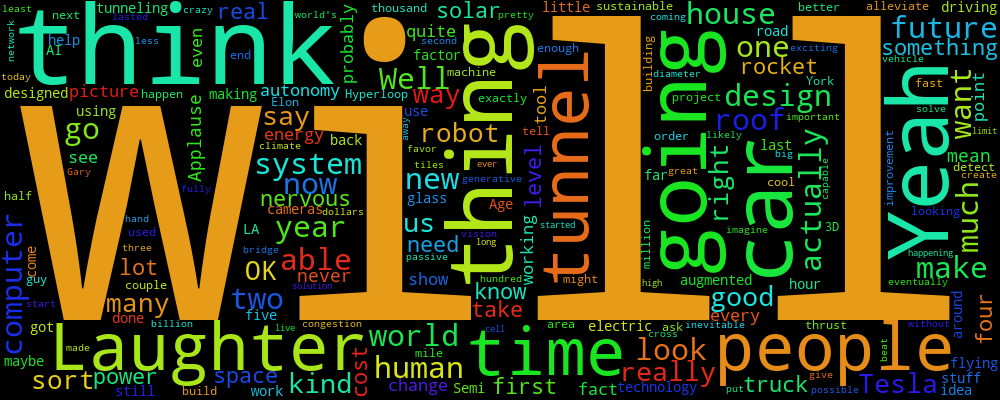

In [53]:
#read the 8th sheet from the excel file - that has the transcripts
df_withTranscript_2017 = pd.read_excel(xlsx, 7)

#read only transcripts of Fascinating and Inspiring talks 
transcript_fascinating_inspiring= df_withTranscript_2017.loc[df_withTranscript_2017['Tags'] == 'Fascinating, Inspiring', 'Tag Words']
mergedTranscript= pd.DataFrame(transcript_fascinating_inspiring)
transcript_for_wordcloud= ""
mergedTranscript = list(mergedTranscript["Tag Words"])

#Merge the transcripts
for i in range(len(mergedTranscript)):
    transcript_for_wordcloud=transcript_for_wordcloud+" "+mergedTranscript[i]
    

#generate word cloud
r= transcript_for_wordcloud.replace("EM", "").replace("CA","")
wc = WordCloud(width=1000,height=400).generate(re.sub(r"\s+"," ", r))
wc.to_image()

We see that the word cloud has the following words highlighted:
# "Will" , "think", "going", "future", "Laughter", "Yeah" 

These words are indicative of the fact that the speech was indeed motivating and had a positive connotation by making use of a good blend of inspirational and funny components.

# 2.2 Sentiment Analysis

We shall now calcualte the sentiment for the transcripts of the speeches using a simple NaiveBayesClassfier approach. The dictionary of positive and negative words are sourced from the WordDcitionary.xlsx file and stored in the positive_vocab and negative_vocab data frames. The training features are the formed based on the vocabulary and the transcript is then classfied based on the words that are encountered. The function thus returns a negative and positive sentiment value as tuple.


In [14]:
#read the Wod Dictionary file and store it in the data frame for sentiment analysis
xl_wordDict= pd.ExcelFile('Word_Dictionary.xlsx',encoding = "ISO-8859-1",dtype='utf-8')
wordlist=pd.read_excel(xl_wordDict,0)

In [52]:
#function for sentiment analysis

#create a dictionary for each word from the data frame
def create_dictionary(word):
    return dict([(word, (True))])

 
positive_vocab = list(wordlist.loc[wordlist['Sentiment'] == 'positive', 'Word'].dropna())
negative_vocab = list(wordlist.loc[wordlist['Sentiment'] == 'negative', 'Word'].dropna())
neutral_vocab=[]

positive_features = [(create_dictionary(pos), 'pos') for pos in positive_vocab]
negative_features = [(create_dictionary(neg), 'neg') for neg in negative_vocab]
neutral_features = [(create_dictionary(neu), 'neu') for neu in neutral_vocab]

#create a training set
train_set = negative_features + positive_features + neutral_features
 
classifier = NaiveBayesClassifier.train(train_set) 

def generateSentiment(r):
    
    # Predict
    neg = 0
    pos = 0
    sentence = r.lower()
    words = sentence.split(' ')
    for word in words:
        classResult = classifier.classify(create_dictionary(word))
        if classResult == 'neg':
            neg = neg + 1
        if classResult == 'pos':
            pos = pos + 1

    return str(float(pos)/len(words)), str(float(neg)/len(words))

# Reference: https://pythonspot.com/python-sentiment-analysis/

     Transcript     Score Sentiment
0  Transcript 1  0.919347  Positive
1  Transcript 1  0.080653  Negative
2  Transcript 2  0.913411  Positive
3  Transcript 2  0.086589  Negative


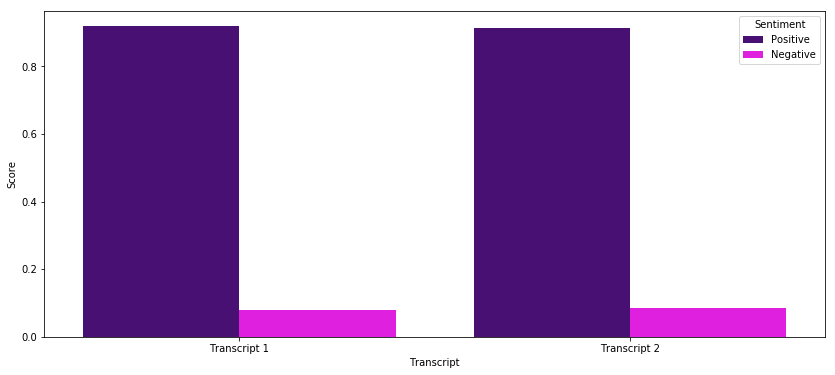

In [58]:
#calculate the sentiment score for Fascinating and Inspiring Talks
sentiment_Fascinating_Df=pd.DataFrame(columns=['Transcript', 'Score', 'Sentiment'])
sentiment_Fascinating_Df.loc[0]=['Transcript 1', generateSentiment(mergedTranscript[0])[0],'Positive']
sentiment_Fascinating_Df.loc[1]=['Transcript 1', generateSentiment(mergedTranscript[0])[1],'Negative']
sentiment_Fascinating_Df.loc[2]=['Transcript 2', generateSentiment(mergedTranscript[1])[0],'Positive']
sentiment_Fascinating_Df.loc[3]=['Transcript 2', generateSentiment(mergedTranscript[1])[1],'Negative']

sentiment_Fascinating_Df['Score']=sentiment_Fascinating_Df['Score'].astype(np.float64)
print(sentiment_Fascinating_Df)

colors=['indigo','fuchsia', 'green']
sea.barplot(x="Transcript", y="Score", hue="Sentiment",data=sentiment_Fascinating_Df, palette=colors, )

sea.set_style({'font.family':'Helvetica', 'font.serif':'Arial'})
plt.rcParams['figure.figsize']=(14,6)

Text(0,0.5,'')

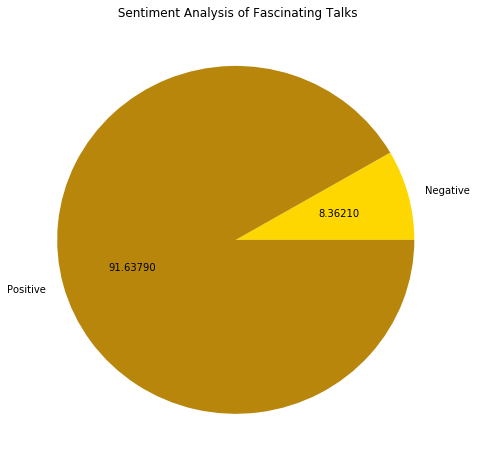

In [59]:
#plot a pie chart of sentiment score for the above trasncripts
colors=['gold','darkgoldenrod', 'lemonchiffon']
sums = sentiment_Fascinating_Df.Score.groupby(sentiment_Fascinating_Df.Sentiment).mean()
piechart=sums.plot.pie(figsize=(8,8), title=' Sentiment Analysis of Fascinating Talks',autopct='%.5f', colors=colors, labels=['Negative', 'Positive'])
piechart.set_ylabel('')

The above graphs show us that the Fascinating Talks had a high Positive Sentiment and a very less negative sentiment attached to the trasncripts. 

# Tag based Sentiment Analysis

Now let us group all the tags and look at their Sentiment Score.

In [61]:
Positive_Sentiment=[]
Negative_Sentiment=[]
NetSentiment=[]

#calculate sentiment for all transcripts

for item in df_withTranscript_2017['Tag Words']:
    Positive_Sentiment.append(generateSentiment(item)[0])
    Negative_Sentiment.append(generateSentiment(item)[1])
    
#appednd the sentiment to data frame

df_withTranscript_2017['Positive Sentiment']=Positive_Sentiment
df_withTranscript_2017['Positive Sentiment']=df_withTranscript_2017['Positive Sentiment'].astype(np.float64)
df_withTranscript_2017['Negative Sentiment']=Negative_Sentiment
df_withTranscript_2017['Negative Sentiment']=df_withTranscript_2017['Negative Sentiment'].astype(np.float64)


 Tags with Maximum Views
                            Views  NetSentiment
Tags                                          
Fascinating, Inspiring  305.6339     83.275806

 Tags with Maximum Views
                            Views  NetSentiment
Tags                                          
Persuasive, Informative  39.8226     90.539721


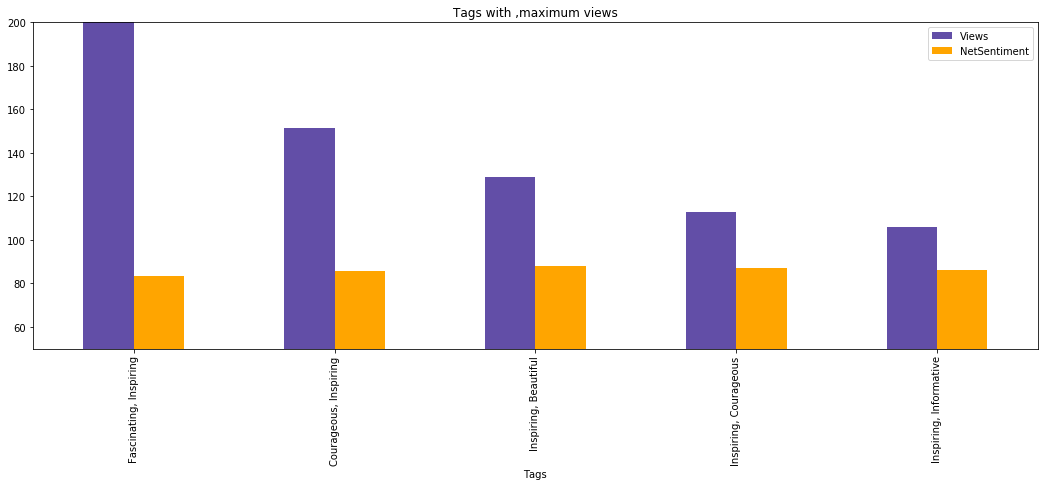

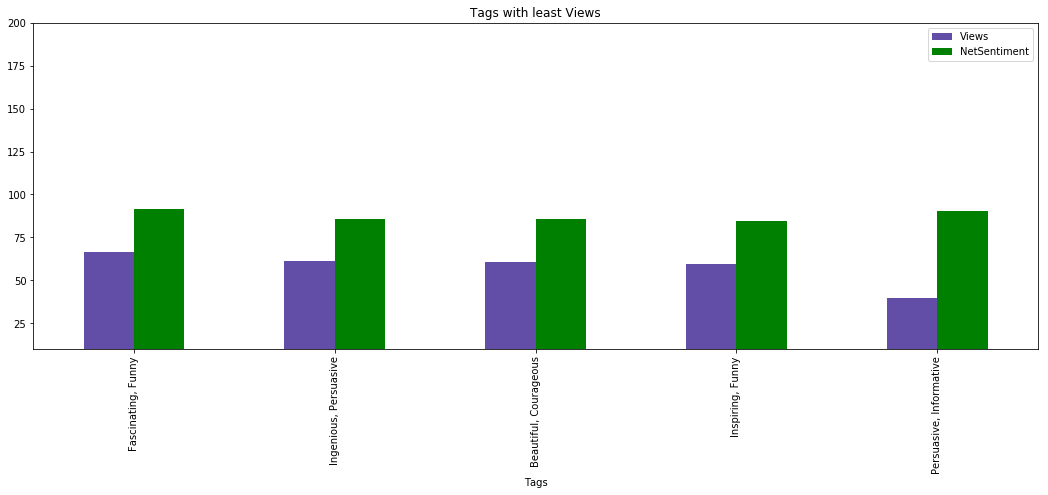

In [62]:
sentiment_byTags = df_withTranscript_2017.groupby('Tags').agg({'Positive Sentiment':'mean', 'Negative Sentiment':'mean', 'date_published':'mean'})
sentiment_byTags['Positive Sentiment']=sentiment_byTags['Positive Sentiment']*100
sentiment_byTags['Negative Sentiment']=sentiment_byTags['Negative Sentiment']*100
sentiment_byTags['Views']=sentiment_byTags['date_published']/10000
sentiment_byTags['NetSentiment']=sentiment_byTags['Positive Sentiment']-sentiment_byTags['Negative Sentiment']

#compare tags with max and min views along with the sentiment score
colors = ['#624ea7', 'orange', '#624ea7', 'green', 'maroon']
print("\n Tags with Maximum Views\n",sentiment_byTags[['Views','NetSentiment']].sort_values('Views',ascending=False).head(1))
print("\n Tags with Maximum Views\n", sentiment_byTags[['Views','NetSentiment']].sort_values('Views',ascending=False).tail(1))
sentiment_byTags[['Views','NetSentiment']].sort_values('Views',ascending=False).head(5).plot.bar(color=colors,figsize=(18,6), title='Tags with ,maximum views', ylim=(50,200))
sentiment_byTags[['Views','NetSentiment']].sort_values('Views',ascending=False).tail(5).plot.bar(color=colors[2:],figsize=(18,6), title='Tags with least Views',ylim=(10,200))

# An interesting observation is that talks that the least number of views had a very high Net Sentiment i.e. Net Sentiment >90 where as talks with the Highest views had a net sentiment lesser than <83.

This drives us to the conclusion that talks that narrate the hardships (which contributed to the lower net sentiment value) that speaker faced could inspire people more than talks that just gave monotonous information which did not have a significant impact on the audience.

2018-10-17    32
2018-08-17    30
2018-11-17    30
2018-09-17    27
2018-03-17    24
2018-12-17    23
2018-05-17    22
2018-04-17    22
2018-02-17    21
2018-01-17    20
2018-06-17    19
2018-07-17    16
Name: Date, dtype: int64
AxesSubplot(0.125,0.2;0.775x0.68)


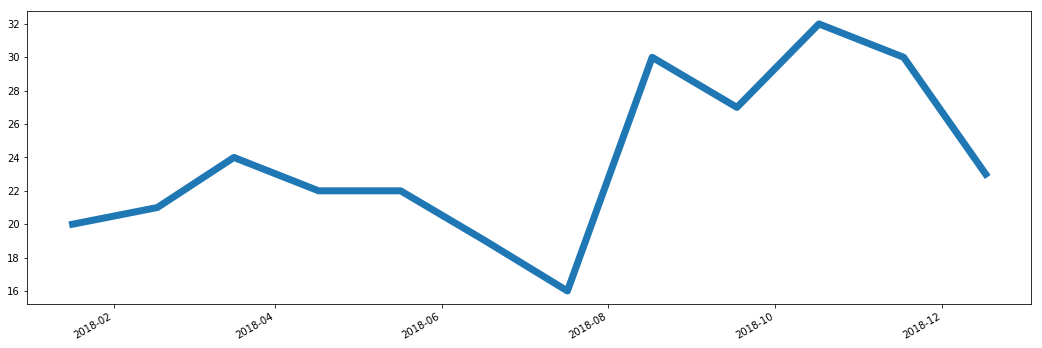

In [63]:
#group by dates
date_df = df_perTalk.sort_values(by=['Date'])
count_date_df = date_df['Date'].value_counts()
print(count_date_df)
print(count_date_df.plot(linewidth=7, figsize=(18,6)))

We see that months September to November have seen a hike in the numbre of views. We speculate th
# 2.4 Social Media Analysis

Now lets group the speakers with the maximum views and look at how their twitter follower count impacts their views

                Speaker  Follower Count      Views
0             Elon Musk      21289582.0  9704367.0
1        Shah Rukh Khan      34929626.0  6167864.0
2    Megan Phelps-Roper         51284.0  5556303.0
3             Anil Seth         11432.0  4628181.0
4           Tim Ferriss       1545374.0  4574226.0
5            Adam Grant        151676.0  4292685.0
6  Emily Esfahani Smith          7423.0  3849023.0
7           Sue Klebold           119.0  3792197.0
AxesSubplot(0.125,0.125;0.775x0.755)


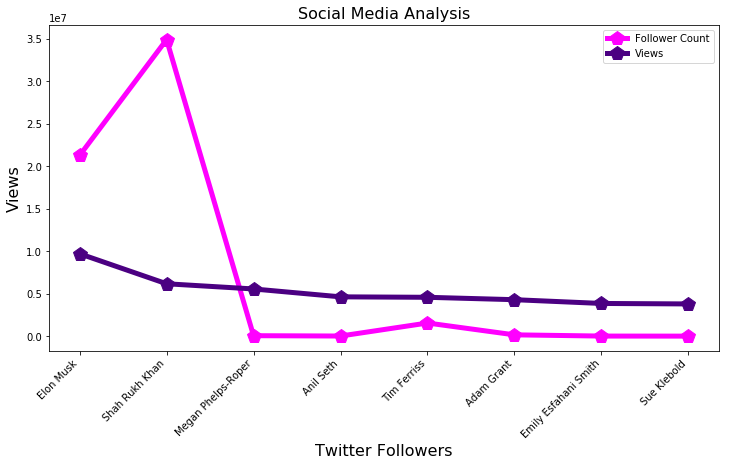

In [46]:
views_date = df_withTranscript_2017.groupby('duration').agg({'date_published':'sum','Positive Sentiment':'mean', 'Negative Sentiment':'mean'})
views_speaker = df_perTalk.groupby('Speaker').agg({'Views':'sum'})

top_speakers = views_speaker.sort_values(by=['Views'],ascending=False)
top_speakers.rename(index=str, columns={"Speaker": "Speaker", "Views": "views"})
df_twitter = pd.read_excel(xlsx, 8)

requireddf=df_twitter.merge(df_perTalk, left_on='Speaker', right_on='Speaker', how='outer')
requireddf= requireddf.filter(['Speaker','Follower Count','Views'], axis=1).head(8)
print(requireddf)

requireddf['Follower Count']=requireddf['Follower Count'].astype(np.float64)
requireddf['Views']=requireddf['Views'].astype(np.float64)

define_font = {'fontname':'Helvetica', 'size':'16'}

plot3=requireddf.plot(color=["fuchsia","indigo","green"], figsize= (12, 6), kind='line', marker='p', linewidth=5, markersize=15)
plot3.set_xticklabels(requireddf.iloc[:,0], rotation=45, ha="right")
plot3.set_xticks(np.arange(len(requireddf.iloc[:,0])))

plot3.set_xlabel('Twitter Followers', **define_font,)
plot3.set_ylabel('Views',**define_font,)
plot3.set_title('Social Media Analysis' ,**define_font,)
print(plot3)

  Event Type Count       Views
0       Tedx    43   95.398621
1        Ted    75  101.178105


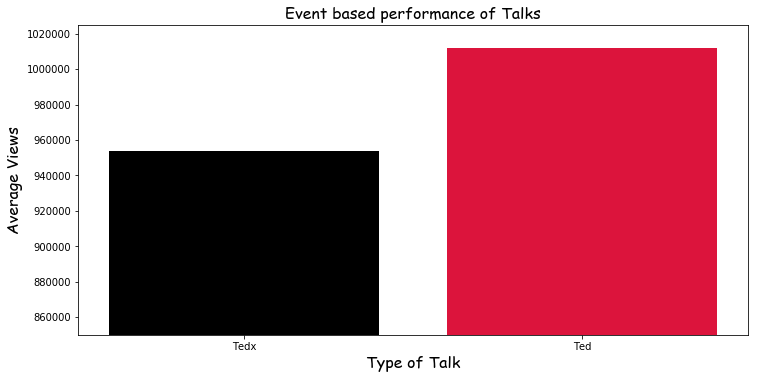

In [45]:
df_transcript = pd.read_excel(xlsx, 7)
type = df_transcript['year_filmed']
#print(type)
tedx = 0
ted = 0
view1=0
view2=0
for i in range(0,len(type)):
    if 'TEDx' in type[i]:
        tedx = tedx + 1
        view1=view1+df_transcript.iloc[i]['date_published']
    else:
        ted = ted + 1
        view2=view2+df_transcript.iloc[i]['date_published']

event_df= pd.DataFrame(columns=['Event Type','Count','Views'])
event_df.loc[0]=['Tedx',tedx, view1/tedx/10000]
event_df.loc[1]=['Ted', ted, view2/ted/10000]

print(event_df)
define_font = {'fontname':'Comic Sans MS', 'size':'16'}


plt.bar(['Tedx', 'Ted'],[view1/tedx, view2/ted], color=['black', 'crimson'])
plt.ylim(850000,1025000)
plt.xlabel('Type of Talk', **define_font,)
plt.ylabel('Average Views',**define_font,)
plt.title('Event based performance of Talks' ,**define_font,)

# plt.figure(figsize=(3,3))
rcParams['figure.figsize'] = 12,5.7

Create a correlation plot against the number of views for various parameters.

AxesSubplot(0.125,0.125;0.775x0.755)


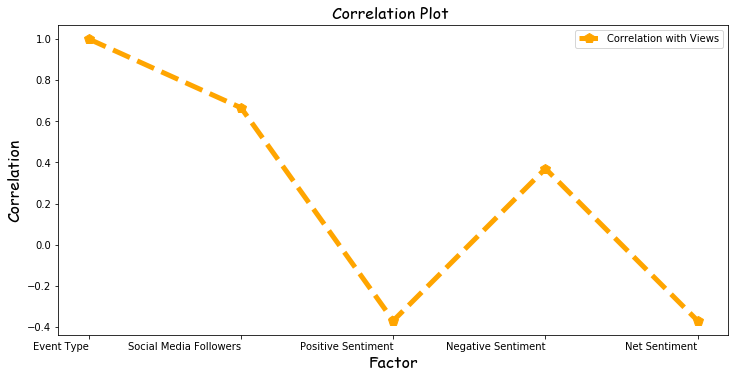

In [42]:
#calulate correlation of event type with Views
event_df['Count']=event_df['Count'].astype(np.float64)
event_df['Views']=event_df['Views'].astype(np.float64)
event_df['Count'].corr(event_df['Views'])
data = event_df[['Count','Views']]
event_correlation = data.corr(method='pearson')

#calulate correlation of Follower Count type with Views
data = requireddf[['Follower Count','Views']]
twitter_correlation = data.corr(method='pearson')

#calulate correlation of Sentiment type with Views
data = sentiment_byTags[['Positive Sentiment','Negative Sentiment','NetSentiment','Views']]
sentiment_correlation = data.corr(method='pearson')


correlationdf=pd.DataFrame(columns=['Factor', 'Correlation with Views'])
correlationdf.loc[0]=['Event Type', event_correlation.Count[0]]
correlationdf.loc[1]=['Social Media Followers', twitter_correlation.Views[0]]
correlationdf.loc[2]=['Positive Sentiment', sentiment_correlation.Views[0]]
correlationdf.loc[3]=['Negative Sentiment', sentiment_correlation.Views[1]]
correlationdf.loc[4]=['Net Sentiment', sentiment_correlation.Views[2]]

plot4=correlationdf.plot(kind='line', linewidth=5, marker='p', markersize='10',color='orange', linestyle='dashed')

plot4.set_xticklabels(correlationdf.iloc[:,0], rotation=0, ha="right")
plot4.set_xticks(np.arange(len(correlationdf.iloc[:,0])))

plot4.set_xlabel('Factor', **define_font,)
plot4.set_ylabel('Correlation',**define_font,)
plot4.set_title('Correlation Plot ' ,**define_font,)
print(plot4)

We see that Event Type (TED/TEDx) has the highes positive correlation with Views i.e. a correlation of 1 and Twitter followers have the second highest positive correlation of 0.663 with Views and last is the negative sentiment which has a positive correlation of 0.34. 

# PART 3 - RECOMMENDATIONS

1. Organize Talks that are 'Insipiring', 'Fascinating' and/or 'Informative' since they are most popular.
2. Talks that focus on the 'future' and have 'laughter' elements are viewed the most. Consider introducing humour in all talks.
3. Have speakers focus more on life stories rather than a monotony of information. These life stories connect to the viewers on a personal level.
4. Have more talks in September, November and December. We speculate that during these months the holiday season is upon us which relates to more talks.
5. Approach speakers with great social presence since their talks tend to generate more traction as compared to those with low or no presence.
6. Independently organized talks are less popular as compared to talks organized by TED itself. Organize more of the latter.